# FIKH Model: Startup Shear

## Protocol-Specific Context

This notebook demonstrates **FIKH startup shear** predictions where the fractional order $\alpha$ critically affects:

1. **Stress overshoot timing**: Lower $\alpha$ → broader overshoot, longer tail
2. **Approach to steady state**: Power-law decay $\sim t^{-\alpha}$ (not exponential)
3. **Structure breakdown dynamics**: Mittag-Leffler decay vs classical exponential

**Why this matters**: Startup transients reveal the **power-law memory** that distinguishes FIKH from classical IKH ($\alpha=1$). The overshoot shape and decay provide direct constraints on $\alpha$.

> **Key physics**: During startup, structure $\lambda$ breaks down via $D_t^{\alpha} \lambda = -\Gamma \lambda |\dot{\gamma}|$. The Caputo derivative produces Mittag-Leffler relaxation $E_{\alpha}(-(t/\tau)^{\alpha})$ which interpolates between stretched exponential (short time) and power-law tail (long time).

> **Handbook:** See [FIKH Startup Protocol](../../docs/source/models/fikh/fikh.rst#start-up-of-steady-shear) for theory and parameter interpretation.

## Learning Objectives

1. Generate synthetic startup shear data using FIKH calibrated parameters
2. Observe how $\alpha$ affects stress overshoot shape and decay
3. Fit FIKH to startup data and recover calibrated $\alpha$
4. Compare fractional vs classical ($\alpha=1$) overshoot dynamics
5. Validate Bayesian inference on transient protocol

## Prerequisites

- NB01: Flow curve (parameter calibration)
- Understanding of Maxwell overshoot in startup shear

**Estimated Time:** 3-5 minutes (fast), 12-18 minutes (full)

## 1. Setup

In [1]:
# Google Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
# Imports
%matplotlib inline
import os
import sys
import time
import warnings

# Add examples/utils to path
# Robust path resolution for execution from any directory
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.fikh import FIKH

_nb_dir = Path(__file__).parent if "__file__" in dir() else Path.cwd()
_utils_candidates = [_nb_dir / ".." / "utils", Path("examples/utils"), _nb_dir.parent / "utils"]
for _p in _utils_candidates:
    if (_p / "fikh_tutorial_utils.py").exists():
        sys.path.insert(0, str(_p.resolve()))
        break
from fikh_tutorial_utils import (
    compute_fit_quality,
    get_fikh_param_names,
    load_pnas_startup,
    plot_alpha_sweep,
    print_alpha_interpretation,
    print_convergence_summary,
    print_parameter_comparison,
    save_fikh_results,
)

# Shared plotting utilities
sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

# FAST_MODE: controlled by environment variable
FAST_MODE = os.environ.get("FAST_MODE", "1") == "1"

jax, jnp = safe_import_jax()
verify_float64()

print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")
print(f"FAST_MODE: {FAST_MODE}")

JAX version: 0.8.3
Devices: [CpuDevice(id=0)]
FAST_MODE: True


## 2. Theory: Startup Shear with Fractional Memory

During startup shear at constant rate $\dot{\gamma}$, the FIKH model predicts:

1. **Initial elastic response**: $\sigma \approx G \cdot \gamma$
2. **Stress overshoot**: Peak occurs when plastic flow begins
3. **Steady-state approach**: Governed by structure evolution

### Alpha Effect on Startup

The fractional order $\alpha$ affects:
- **Overshoot timing**: Lower $\alpha$ → later peak (slower structure breakdown)
- **Overshoot magnitude**: Modified by memory kernel
- **Approach to steady-state**: Power-law vs exponential convergence

## 3. Load Data

In [3]:
# Load PNAS startup data at gamma_dot = 1.0 s^-1
GAMMA_DOT = 1.0
time_data, stress_data = load_pnas_startup(gamma_dot=GAMMA_DOT)

print(f"Data points: {len(time_data)}")
print(f"Time range: [{time_data.min():.4f}, {time_data.max():.2f}] s")
print(f"Stress range: [{stress_data.min():.2f}, {stress_data.max():.2f}] Pa")
print(f"Shear rate: {GAMMA_DOT} 1/s")

Data points: 500
Time range: [0.0053, 600.00] s
Stress range: [0.69, 26.77] Pa
Shear rate: 1.0 1/s


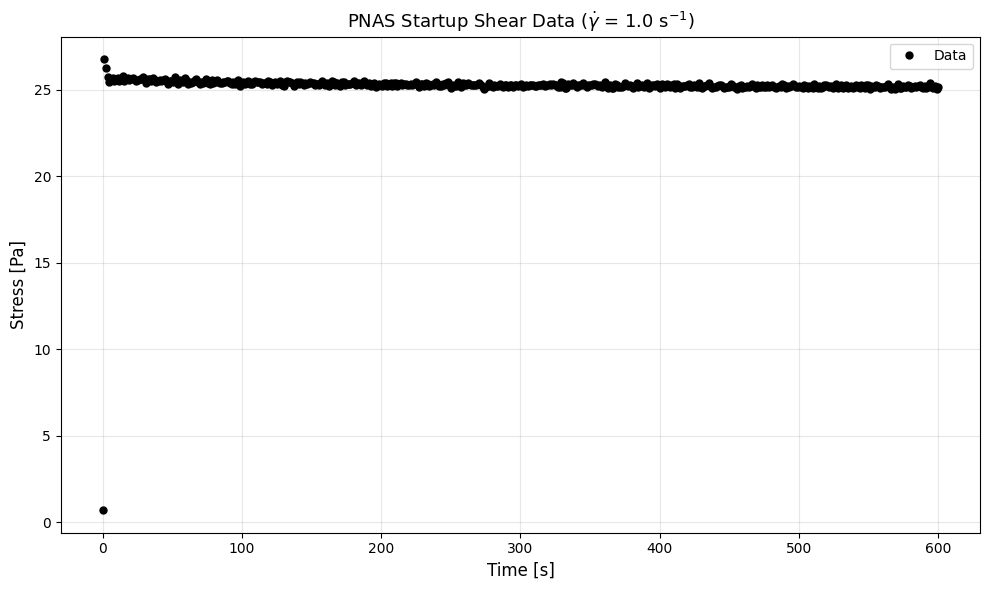

In [4]:
# Plot raw data
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(time_data, stress_data, "ko", markersize=5, label="Data")
ax.set_xlabel("Time [s]", fontsize=12)
ax.set_ylabel("Stress [Pa]", fontsize=12)
ax.set_title(f"PNAS Startup Shear Data ($\\dot{{\\gamma}}$ = {GAMMA_DOT} s$^{{-1}}$)", fontsize=13)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
display(fig)
plt.close(fig)

## 4. NLSQ Fitting

In [5]:
# Create and fit FIKH model
model = FIKH(include_thermal=False, alpha_structure=0.7)

# Compute strain from time and shear rate
strain_data = GAMMA_DOT * time_data

t0 = time.time()
model.fit(time_data, stress_data, test_mode="startup", strain=strain_data, method='scipy')
t_nlsq = time.time() - t0

param_names = get_fikh_param_names(include_thermal=False)

print(f"NLSQ fit time: {t_nlsq:.2f} s")
print(f"\nFitted parameters:")
for name in param_names:
    val = model.parameters.get_value(name)
    print(f"  {name:15s} = {val:.4g}")

ERROR:rheojax.core.base:Predict failed
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/core/base.py", line 713, in predict
    result = self._predict(X, **kwargs)
  File "/Users/b80985/Projects/rheojax/rheojax/models/fikh/fikh.py", line 475, in _predict
    times, strains = self._extract_time_strain(X, **kwargs)
                     ~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/rheojax/models/fikh/_base.py", line 335, in _extract_time_strain
    raise ValueError(
    ...<2 lines>...
    )
ValueError: FIKH models require both time and strain history. Pass RheoData, X of shape (2, N), or X=time with strain kwarg.


NLSQ fit time: 0.17 s

Fitted parameters:
  G               = 282.8
  eta             = 3.135e+07
  C               = 499.6
  gamma_dyn       = 1.899
  m               = 1
  sigma_y0        = 9.99
  delta_sigma_y   = 49.93
  tau_thix        = 94.25
  Gamma           = 2.728
  alpha_structure = 0.703
  eta_inf         = 0.09986
  mu_p            = 0.001



Fit Quality:
  R^2:   -44419.068507
  RMSE:  234.3 Pa


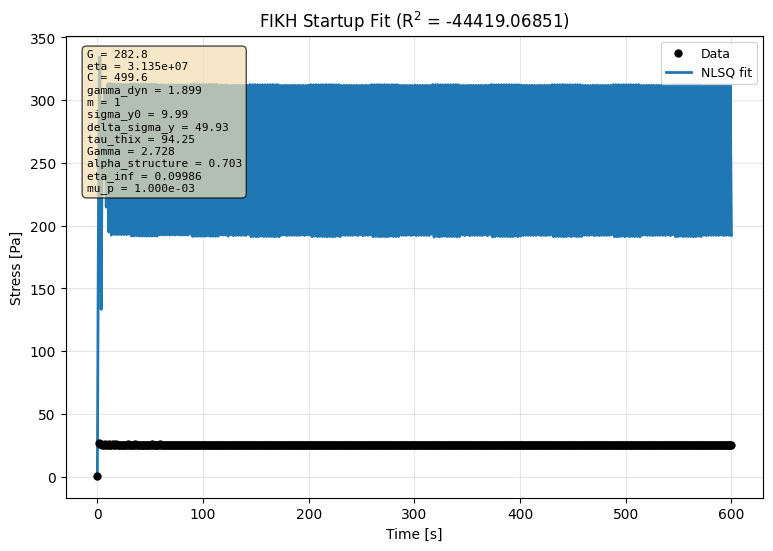

In [6]:
# Compute fit quality and plot with uncertainty band
stress_pred = model.predict(time_data, test_mode="startup", strain=strain_data)
metrics = compute_fit_quality(stress_data, stress_pred)

print(f"\nFit Quality:")
print(f"  R^2:   {metrics['R2']:.6f}")
print(f"  RMSE:  {metrics['RMSE']:.4g} Pa")

fig, ax = plot_nlsq_fit(
    time_data, stress_data, model, test_mode="startup",
    param_names=param_names, log_scale=False,
    xlabel="Time [s]", ylabel="Stress [Pa]",
    title=f"FIKH Startup Fit (R$^2$ = {metrics['R2']:.5f})",
    x_pred=time_data,
    strain=strain_data,
)
display(fig)
plt.close(fig)

## 5. Alpha Exploration

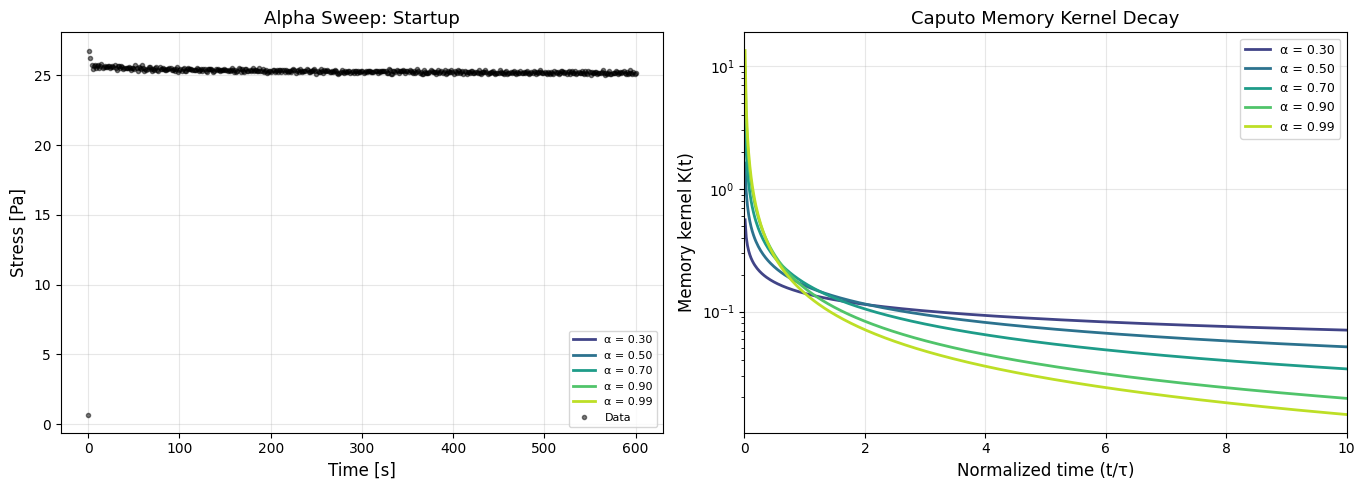

In [7]:
# Define fine time grid for alpha sweep
time_fine = np.linspace(time_data.min(), time_data.max(), 200)

# Alpha sweep for startup shear
alpha_values = [0.3, 0.5, 0.7, 0.9, 0.99]

fig = plot_alpha_sweep(
    model,
    protocol="startup",
    alpha_values=alpha_values,
    x_data=time_fine,
    gamma_dot=GAMMA_DOT,
    figsize=(14, 5),
)

# Add data to left panel
fig.axes[0].plot(time_data, stress_data, "ko", markersize=3, alpha=0.5, label="Data")
fig.axes[0].legend(fontsize=8, loc="best")

display(fig)
plt.close(fig)

In [8]:
# Physical interpretation
fitted_alpha = model.parameters.get_value("alpha_structure")
print_alpha_interpretation(fitted_alpha)

Fractional Order Interpretation: α = 0.703

Regime: Weak Memory

Approaching classical behavior with mild power-law tails.
Recovery is mostly exponential with slow corrections.
Suitable for: Mildly thixotropic materials.

Physical Implications:
  • Memory kernel decay: t^(-0.70)
  • Recovery time scale: > τ_thix × Γ(1+0.70) = 0.91 × τ_thix
  • Relaxation modulus: Power-law with exponent ≈ -0.70


## 6. Bayesian Inference

In [9]:
# Bayesian inference with NLSQ warm-start
initial_values = {name: model.parameters.get_value(name) for name in param_names}

NUM_WARMUP = 200
NUM_SAMPLES = 500
NUM_CHAINS = 1
# NUM_WARMUP = 1000; NUM_SAMPLES = 2000; NUM_CHAINS = 4  # production

print(f"Running NUTS: {NUM_WARMUP} warmup + {NUM_SAMPLES} samples x {NUM_CHAINS} chain(s)")
t0 = time.time()
result = model.fit_bayesian(
    time_data,
    stress_data,
    test_mode="startup",
    strain=strain_data,
    num_warmup=NUM_WARMUP,
    num_samples=NUM_SAMPLES,
    num_chains=NUM_CHAINS,
    initial_values=initial_values,
    seed=42,
)
t_bayes = time.time() - t0
print(f"\nBayesian inference time: {t_bayes:.1f} s")

Running NUTS: 200 warmup + 500 samples x 1 chain(s)


  0%|          | 0/700 [00:00<?, ?it/s]

warmup:   0%|          | 1/700 [00:01<19:50,  1.70s/it, 1 steps of size 1.95e+00. acc. prob=0.00]

warmup:   2%|▏         | 16/700 [00:01<00:58, 11.77it/s, 31 steps of size 7.99e-09. acc. prob=0.47]

warmup:   3%|▎         | 23/700 [00:02<00:41, 16.48it/s, 27 steps of size 1.31e-08. acc. prob=0.59]

warmup:   5%|▌         | 38/700 [00:02<00:20, 31.61it/s, 5 steps of size 8.35e-09. acc. prob=0.69] 

warmup:   7%|▋         | 47/700 [00:02<00:16, 39.56it/s, 1 steps of size 1.01e-08. acc. prob=0.72]

warmup:   8%|▊         | 56/700 [00:02<00:14, 43.18it/s, 3 steps of size 1.28e-08. acc. prob=0.74]

warmup:   9%|▉         | 64/700 [00:02<00:14, 42.90it/s, 31 steps of size 1.76e-08. acc. prob=0.75]

warmup:  11%|█         | 77/700 [00:02<00:10, 57.12it/s, 7 steps of size 7.93e-09. acc. prob=0.77] 

warmup:  12%|█▏        | 86/700 [00:02<00:10, 60.82it/s, 7 steps of size 1.71e-08. acc. prob=0.78]

warmup:  14%|█▎        | 96/700 [00:02<00:08, 69.17it/s, 3 steps of size 1.26e-08. acc. prob=0.78]

warmup:  15%|█▌        | 105/700 [00:03<00:19, 29.87it/s, 1 steps of size 3.19e-07. acc. prob=0.79]

warmup:  16%|█▌        | 112/700 [00:03<00:18, 31.27it/s, 7 steps of size 9.48e-08. acc. prob=0.80]

warmup:  17%|█▋        | 119/700 [00:03<00:17, 33.95it/s, 31 steps of size 4.35e-07. acc. prob=0.81]

warmup:  18%|█▊        | 125/700 [00:04<00:15, 36.37it/s, 15 steps of size 5.33e-07. acc. prob=0.81]

warmup:  19%|█▉        | 134/700 [00:04<00:14, 39.16it/s, 31 steps of size 4.38e-07. acc. prob=0.82]

warmup:  20%|█▉        | 139/700 [00:04<00:27, 20.48it/s, 7 steps of size 2.62e-07. acc. prob=0.82] 

warmup:  20%|██        | 143/700 [00:05<00:25, 22.26it/s, 15 steps of size 1.82e-07. acc. prob=0.82]

warmup:  21%|██        | 148/700 [00:05<00:22, 24.19it/s, 31 steps of size 1.30e-07. acc. prob=0.82]

warmup:  22%|██▏       | 152/700 [00:05<00:20, 26.31it/s, 1 steps of size 2.95e-07. acc. prob=0.82] 

warmup:  23%|██▎       | 161/700 [00:05<00:14, 37.32it/s, 3 steps of size 2.64e-07. acc. prob=0.83]

warmup:  24%|██▍       | 168/700 [00:05<00:17, 30.15it/s, 127 steps of size 1.74e-07. acc. prob=0.83]

warmup:  25%|██▍       | 173/700 [00:06<00:31, 16.92it/s, 7 steps of size 1.91e-07. acc. prob=0.83]  

warmup:  26%|██▌       | 180/700 [00:06<00:23, 22.44it/s, 7 steps of size 1.67e-07. acc. prob=0.83]

warmup:  27%|██▋       | 189/700 [00:06<00:21, 23.86it/s, 127 steps of size 2.16e-07. acc. prob=0.84]

warmup:  28%|██▊       | 196/700 [00:07<00:17, 29.62it/s, 3 steps of size 1.49e-07. acc. prob=0.84]  

sample:  29%|██▊       | 201/700 [00:07<00:16, 29.75it/s, 3 steps of size 2.20e-07. acc. prob=1.00]

sample:  30%|███       | 211/700 [00:07<00:11, 41.11it/s, 3 steps of size 2.20e-07. acc. prob=0.97]

sample:  31%|███       | 218/700 [00:07<00:10, 46.52it/s, 7 steps of size 2.20e-07. acc. prob=0.97]

sample:  32%|███▏      | 225/700 [00:07<00:09, 50.59it/s, 15 steps of size 2.20e-07. acc. prob=0.95]

sample:  33%|███▎      | 234/700 [00:07<00:08, 56.94it/s, 31 steps of size 2.20e-07. acc. prob=0.94]

sample:  34%|███▍      | 241/700 [00:07<00:08, 54.61it/s, 31 steps of size 2.20e-07. acc. prob=0.94]

sample:  35%|███▌      | 248/700 [00:07<00:08, 54.10it/s, 3 steps of size 2.20e-07. acc. prob=0.93] 

sample:  36%|███▋      | 254/700 [00:08<00:08, 53.61it/s, 7 steps of size 2.20e-07. acc. prob=0.93]

sample:  37%|███▋      | 260/700 [00:08<00:08, 53.08it/s, 3 steps of size 2.20e-07. acc. prob=0.94]

sample:  38%|███▊      | 269/700 [00:08<00:06, 62.10it/s, 3 steps of size 2.20e-07. acc. prob=0.94]

sample:  40%|███▉      | 279/700 [00:08<00:05, 71.02it/s, 7 steps of size 2.20e-07. acc. prob=0.94]

sample:  41%|████      | 287/700 [00:08<00:09, 41.83it/s, 3 steps of size 2.20e-07. acc. prob=0.93]

sample:  42%|████▏     | 293/700 [00:08<00:09, 44.02it/s, 3 steps of size 2.20e-07. acc. prob=0.93]

sample:  43%|████▎     | 300/700 [00:08<00:08, 47.22it/s, 31 steps of size 2.20e-07. acc. prob=0.93]

sample:  44%|████▍     | 307/700 [00:09<00:07, 51.67it/s, 3 steps of size 2.20e-07. acc. prob=0.92] 

sample:  45%|████▍     | 314/700 [00:09<00:07, 51.12it/s, 31 steps of size 2.20e-07. acc. prob=0.93]

sample:  46%|████▌     | 320/700 [00:09<00:08, 46.34it/s, 7 steps of size 2.20e-07. acc. prob=0.93] 

sample:  47%|████▋     | 329/700 [00:09<00:06, 55.98it/s, 3 steps of size 2.20e-07. acc. prob=0.93]

sample:  48%|████▊     | 337/700 [00:09<00:07, 47.87it/s, 63 steps of size 2.20e-07. acc. prob=0.93]

sample:  50%|████▉     | 348/700 [00:09<00:05, 60.25it/s, 3 steps of size 2.20e-07. acc. prob=0.93] 

sample:  51%|█████     | 355/700 [00:09<00:05, 60.46it/s, 3 steps of size 2.20e-07. acc. prob=0.93]

sample:  52%|█████▏    | 362/700 [00:10<00:08, 39.99it/s, 3 steps of size 2.20e-07. acc. prob=0.92]

sample:  53%|█████▎    | 368/700 [00:10<00:08, 40.47it/s, 3 steps of size 2.20e-07. acc. prob=0.92]

sample:  53%|█████▎    | 373/700 [00:10<00:08, 38.30it/s, 15 steps of size 2.20e-07. acc. prob=0.92]

sample:  54%|█████▍    | 378/700 [00:10<00:12, 26.75it/s, 31 steps of size 2.20e-07. acc. prob=0.92]

sample:  55%|█████▍    | 382/700 [00:11<00:11, 27.59it/s, 7 steps of size 2.20e-07. acc. prob=0.92] 

sample:  55%|█████▌    | 387/700 [00:11<00:10, 30.89it/s, 7 steps of size 2.20e-07. acc. prob=0.92]

sample:  56%|█████▌    | 391/700 [00:11<00:09, 32.49it/s, 3 steps of size 2.20e-07. acc. prob=0.92]

sample:  57%|█████▋    | 396/700 [00:11<00:08, 36.15it/s, 3 steps of size 2.20e-07. acc. prob=0.92]

sample:  58%|█████▊    | 404/700 [00:11<00:06, 45.85it/s, 7 steps of size 2.20e-07. acc. prob=0.92]

sample:  59%|█████▊    | 410/700 [00:11<00:05, 48.76it/s, 15 steps of size 2.20e-07. acc. prob=0.92]

sample:  59%|█████▉    | 416/700 [00:11<00:08, 35.22it/s, 15 steps of size 2.20e-07. acc. prob=0.92]

sample:  61%|██████    | 426/700 [00:11<00:06, 43.86it/s, 31 steps of size 2.20e-07. acc. prob=0.92]

sample:  62%|██████▏   | 432/700 [00:12<00:06, 41.46it/s, 7 steps of size 2.20e-07. acc. prob=0.92] 

sample:  63%|██████▎   | 438/700 [00:12<00:05, 45.27it/s, 7 steps of size 2.20e-07. acc. prob=0.92]

sample:  63%|██████▎   | 444/700 [00:12<00:06, 42.45it/s, 7 steps of size 2.20e-07. acc. prob=0.92]

sample:  64%|██████▍   | 450/700 [00:12<00:05, 45.23it/s, 15 steps of size 2.20e-07. acc. prob=0.92]

sample:  65%|██████▌   | 457/700 [00:12<00:04, 49.85it/s, 15 steps of size 2.20e-07. acc. prob=0.91]

sample:  66%|██████▋   | 465/700 [00:12<00:04, 56.46it/s, 7 steps of size 2.20e-07. acc. prob=0.92] 

sample:  67%|██████▋   | 471/700 [00:12<00:04, 48.97it/s, 15 steps of size 2.20e-07. acc. prob=0.92]

sample:  68%|██████▊   | 477/700 [00:13<00:06, 34.16it/s, 3 steps of size 2.20e-07. acc. prob=0.92] 

sample:  69%|██████▉   | 482/700 [00:13<00:06, 32.01it/s, 7 steps of size 2.20e-07. acc. prob=0.91]

sample:  70%|██████▉   | 488/700 [00:13<00:06, 34.68it/s, 15 steps of size 2.20e-07. acc. prob=0.91]

sample:  71%|███████   | 496/700 [00:13<00:04, 42.98it/s, 3 steps of size 2.20e-07. acc. prob=0.91] 

sample:  72%|███████▏  | 504/700 [00:13<00:03, 50.82it/s, 7 steps of size 2.20e-07. acc. prob=0.91]

sample:  73%|███████▎  | 510/700 [00:13<00:03, 49.50it/s, 3 steps of size 2.20e-07. acc. prob=0.91]

sample:  74%|███████▎  | 516/700 [00:14<00:03, 49.44it/s, 7 steps of size 2.20e-07. acc. prob=0.91]

sample:  75%|███████▍  | 522/700 [00:14<00:03, 50.47it/s, 3 steps of size 2.20e-07. acc. prob=0.91]

sample:  76%|███████▌  | 530/700 [00:14<00:02, 57.76it/s, 3 steps of size 2.20e-07. acc. prob=0.90]

sample:  77%|███████▋  | 538/700 [00:14<00:03, 48.17it/s, 63 steps of size 2.20e-07. acc. prob=0.90]

sample:  78%|███████▊  | 547/700 [00:14<00:02, 54.71it/s, 15 steps of size 2.20e-07. acc. prob=0.90]

sample:  79%|███████▉  | 554/700 [00:14<00:02, 55.97it/s, 15 steps of size 2.20e-07. acc. prob=0.90]

sample:  80%|████████  | 561/700 [00:14<00:02, 58.50it/s, 3 steps of size 2.20e-07. acc. prob=0.90] 

sample:  81%|████████  | 568/700 [00:14<00:02, 53.50it/s, 3 steps of size 2.20e-07. acc. prob=0.90]

sample:  82%|████████▏ | 576/700 [00:15<00:02, 59.29it/s, 7 steps of size 2.20e-07. acc. prob=0.90]

sample:  83%|████████▎ | 583/700 [00:15<00:02, 43.85it/s, 3 steps of size 2.20e-07. acc. prob=0.90]

sample:  84%|████████▍ | 589/700 [00:15<00:02, 46.57it/s, 3 steps of size 2.20e-07. acc. prob=0.90]

sample:  85%|████████▌ | 595/700 [00:15<00:02, 41.08it/s, 7 steps of size 2.20e-07. acc. prob=0.90]

sample:  86%|████████▌ | 601/700 [00:15<00:03, 31.17it/s, 127 steps of size 2.20e-07. acc. prob=0.90]

sample:  87%|████████▋ | 611/700 [00:16<00:02, 41.93it/s, 3 steps of size 2.20e-07. acc. prob=0.90]  

sample:  88%|████████▊ | 617/700 [00:16<00:01, 44.52it/s, 3 steps of size 2.20e-07. acc. prob=0.90]

sample:  89%|████████▉ | 626/700 [00:16<00:01, 53.44it/s, 15 steps of size 2.20e-07. acc. prob=0.89]

sample:  91%|█████████ | 635/700 [00:16<00:01, 42.12it/s, 98 steps of size 2.20e-07. acc. prob=0.89]

sample:  92%|█████████▏| 641/700 [00:16<00:01, 43.64it/s, 7 steps of size 2.20e-07. acc. prob=0.89] 

sample:  93%|█████████▎| 648/700 [00:16<00:01, 48.55it/s, 3 steps of size 2.20e-07. acc. prob=0.89]

sample:  94%|█████████▎| 656/700 [00:17<00:01, 41.54it/s, 87 steps of size 2.20e-07. acc. prob=0.89]

sample:  95%|█████████▌| 667/700 [00:17<00:00, 54.07it/s, 3 steps of size 2.20e-07. acc. prob=0.88] 

sample:  97%|█████████▋| 676/700 [00:17<00:00, 59.50it/s, 7 steps of size 2.20e-07. acc. prob=0.88]

sample:  98%|█████████▊| 683/700 [00:17<00:00, 51.86it/s, 31 steps of size 2.20e-07. acc. prob=0.88]

sample:  99%|█████████▉| 694/700 [00:17<00:00, 63.49it/s, 3 steps of size 2.20e-07. acc. prob=0.87] 

sample: 100%|██████████| 700/700 [00:17<00:00, 39.69it/s, 3 steps of size 2.20e-07. acc. prob=0.87]


Bayesian inference time: 20.2 s


### Convergence Diagnostics

**Bayesian Diagnostic Interpretation:**

| Metric | Target | Interpretation |
|--------|--------|----------------|
| **R-hat** | < 1.01 | Chain convergence (< 1.05 acceptable) |
| **ESS** | > 400 | Effective sample size (> 100 minimum) |
| **Divergences** | < 1% | NUTS sampling quality |

Passing diagnostics ensure reliable parameter estimates and credible intervals.

In [10]:
# Convergence diagnostics
all_pass = print_convergence_summary(result, param_names)

print("\n### Diagnostic Interpretation Table")
print("| Metric | Target | Interpretation |")
print("|--------|--------|----------------|")
print("| R-hat | < 1.01 | Chain convergence (< 1.05 acceptable) |")
print("| ESS | > 400 | Effective sample size (> 100 minimum) |")
print("| Divergences | < 1% | Sampling quality |")

Convergence Diagnostics
      Parameter     R-hat       ESS    Status
-------------------------------------------------------
              G    2.3761         3     CHECK
            eta    2.5498         3     CHECK
              C    2.3801         3     CHECK
      gamma_dyn    2.3830         3     CHECK
              m    2.3734         3     CHECK
       sigma_y0    2.5952         3     CHECK
  delta_sigma_y    2.3641         3     CHECK
       tau_thix    1.0043        10     CHECK
          Gamma    2.3410         3     CHECK
alpha_structure    1.0916         7     CHECK
        eta_inf    1.2699         4     CHECK
           mu_p    1.4558         6     CHECK

Divergences: 2

CHECK REQUIRED: Increase num_warmup/num_samples or check warm-start

### Diagnostic Interpretation Table
| Metric | Target | Interpretation |
|--------|--------|----------------|
| R-hat | < 1.01 | Chain convergence (< 1.05 acceptable) |
| ESS | > 400 | Effective sample size (> 100 minimum) |
| Divergenc

/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/arviz/plots/backends/matplotlib/pairplot.py:223: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


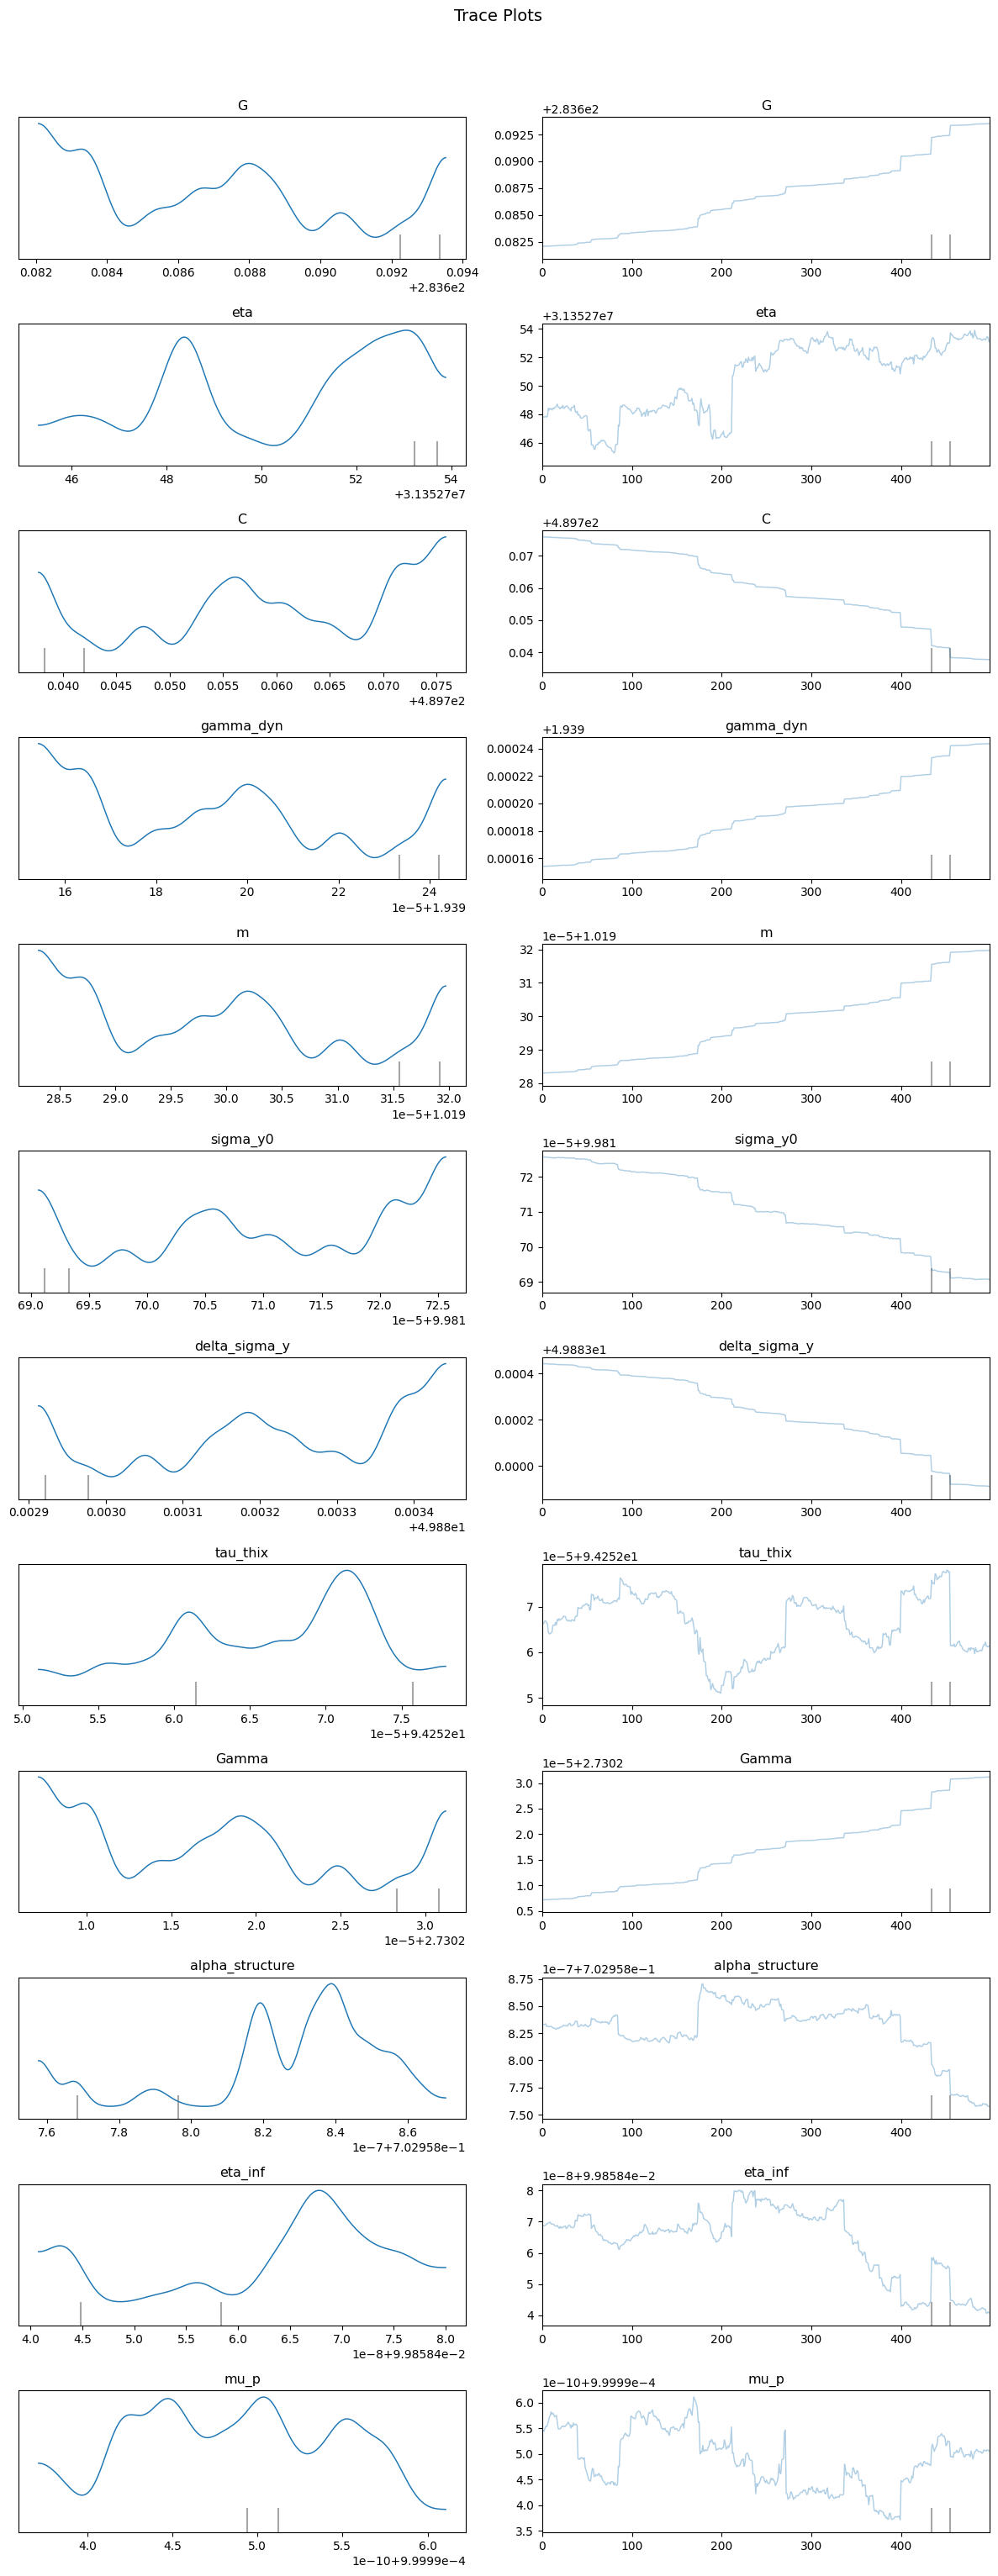

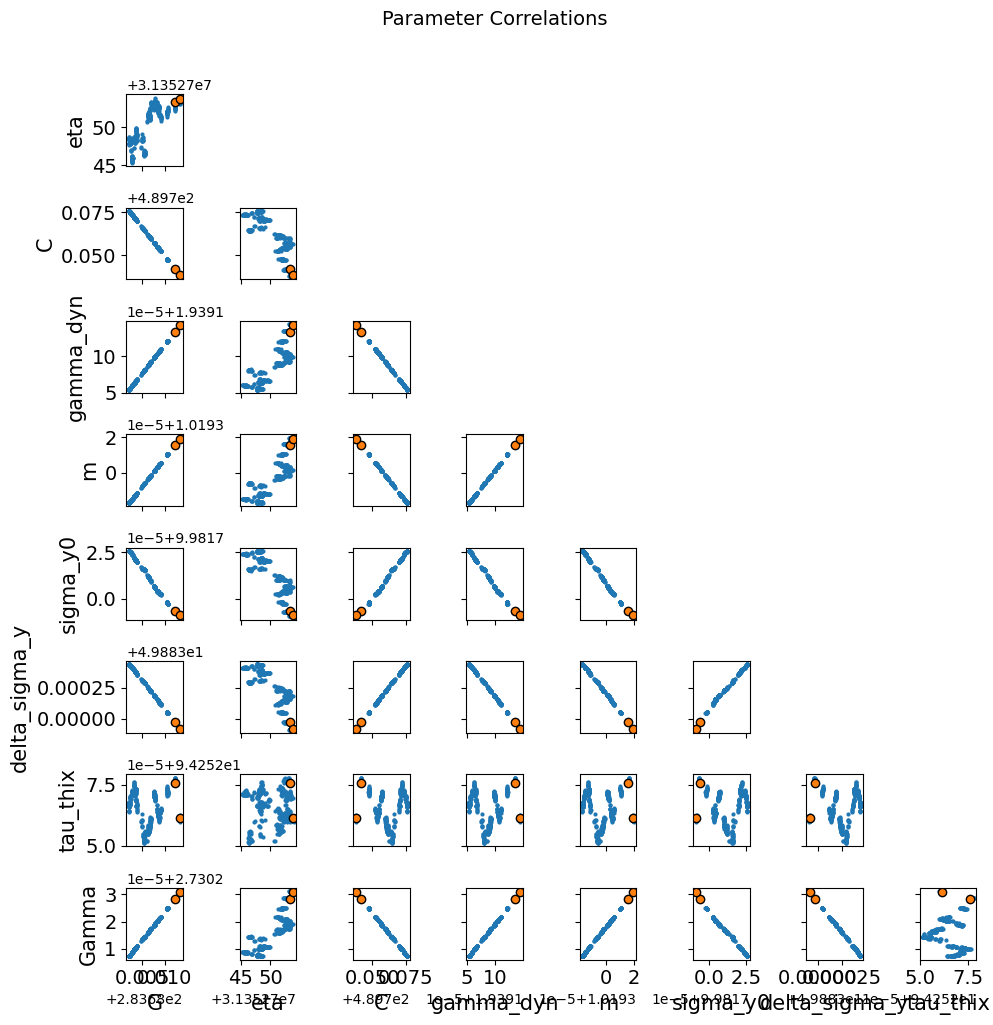

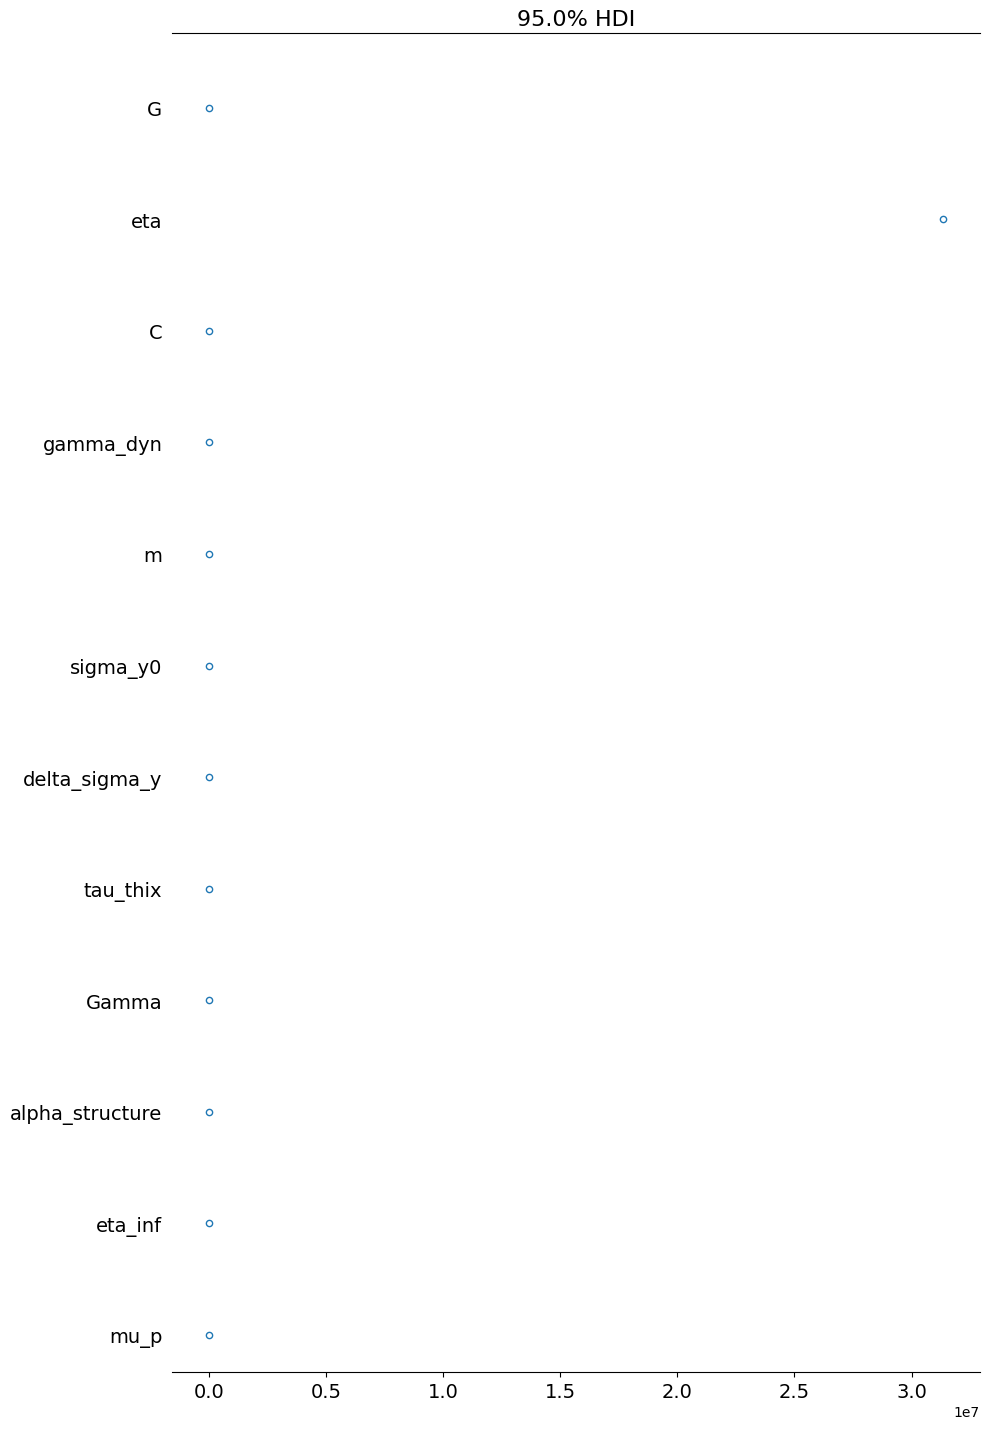

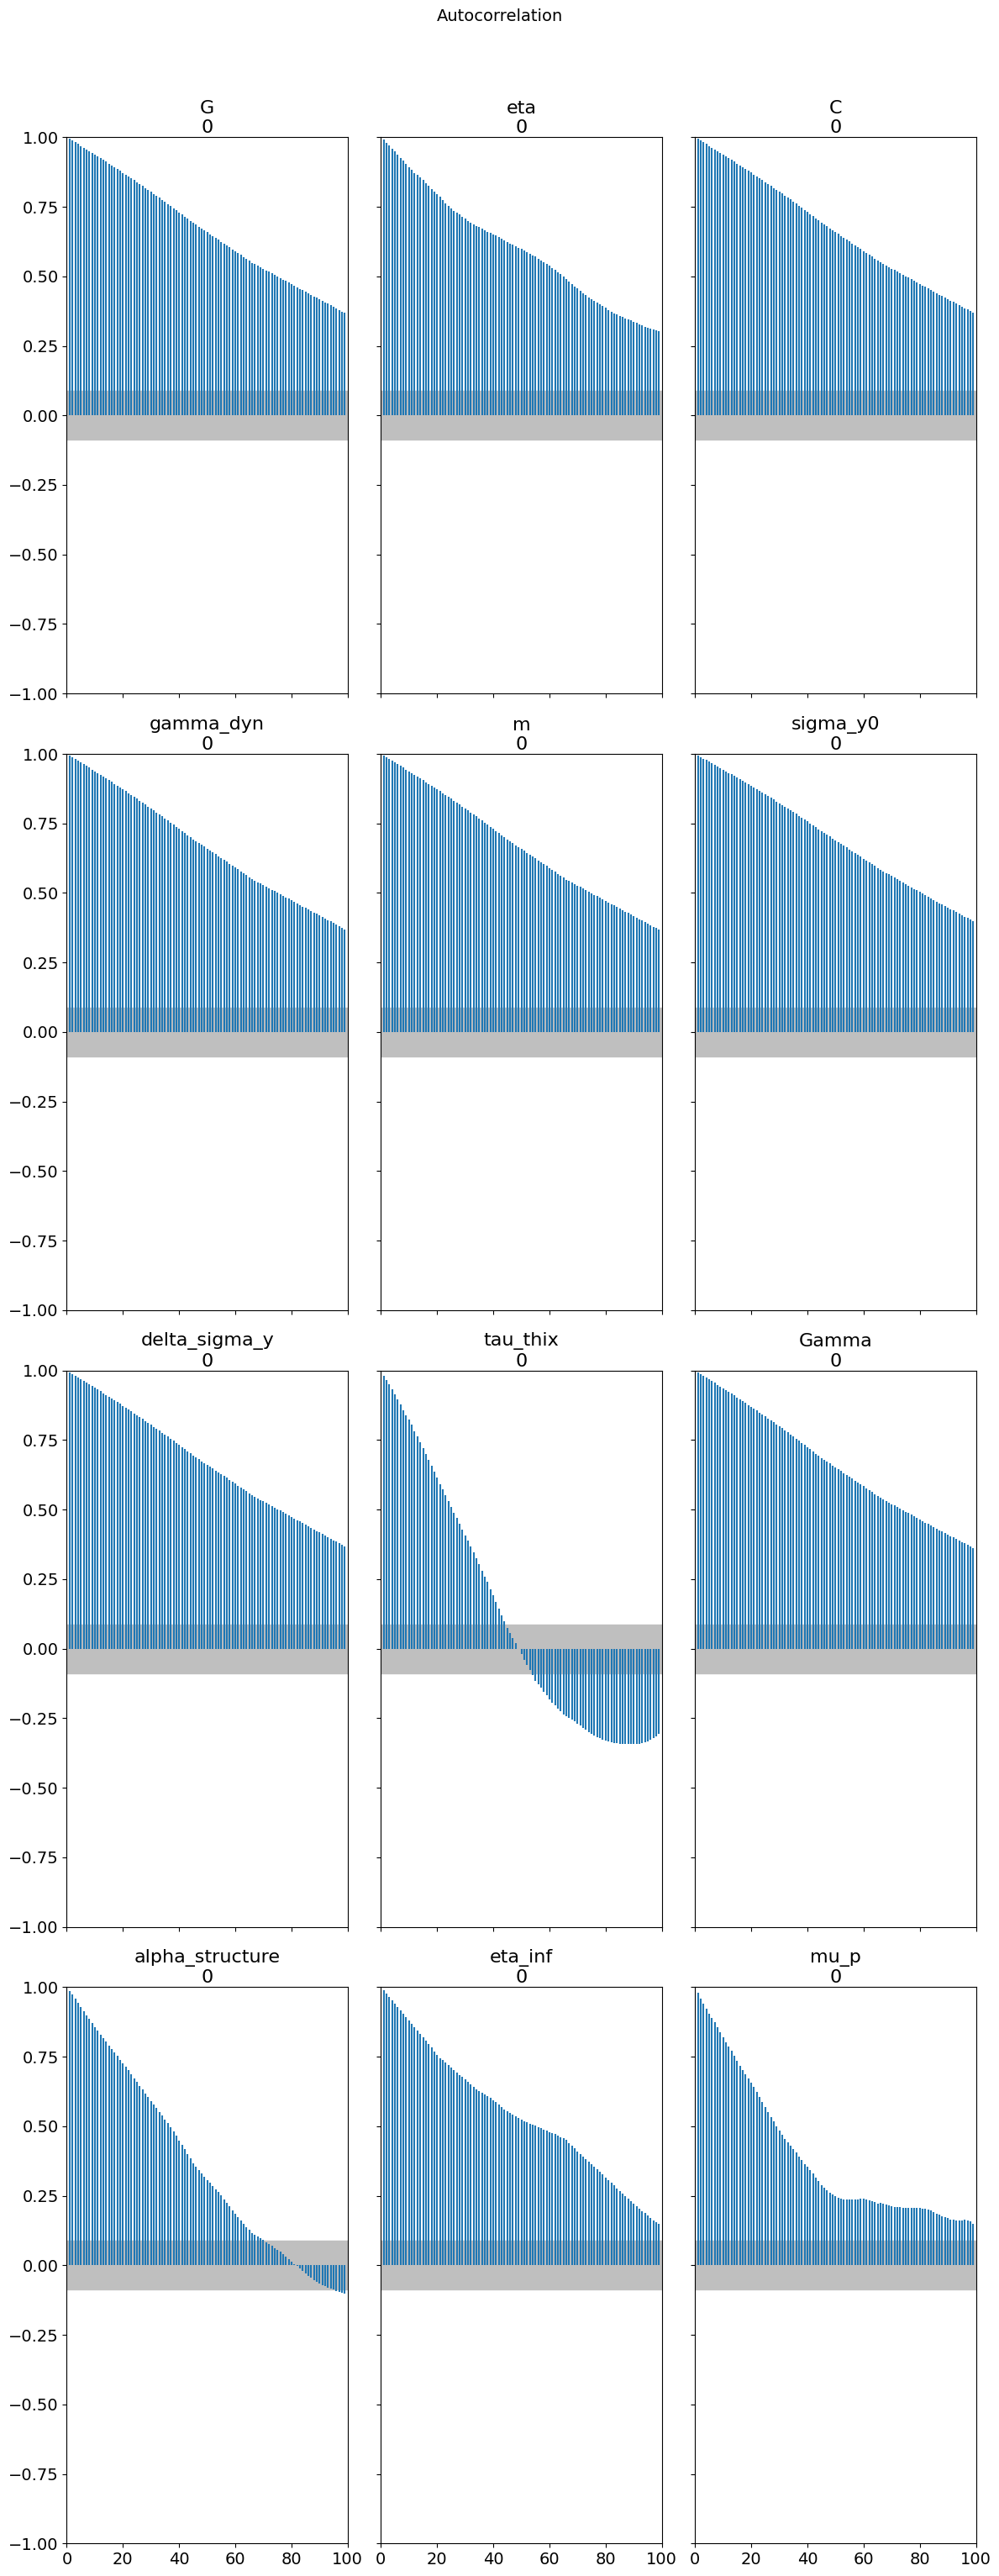

In [11]:
# ArviZ diagnostic plots (trace, pair, forest, energy, autocorr, rank)
display_arviz_diagnostics(result, param_names, fast_mode=FAST_MODE)

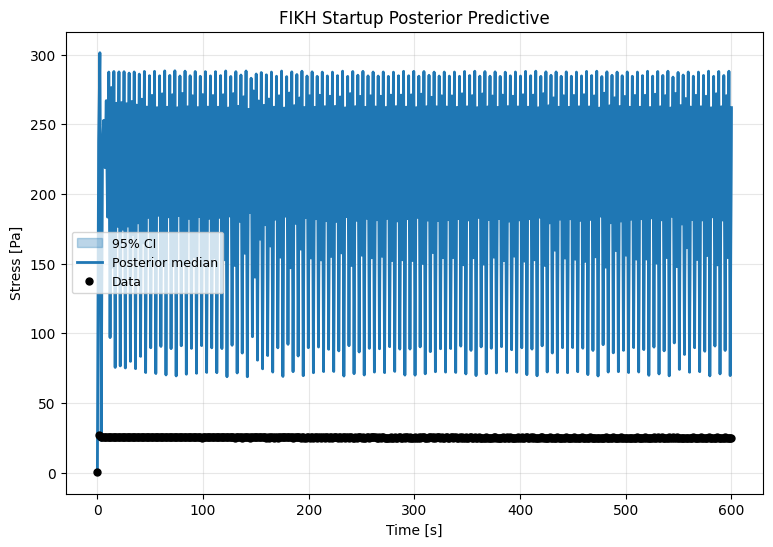

In [12]:
# Posterior predictive with 95% credible intervals
fig, ax = plot_posterior_predictive(
    time_data, stress_data, model, result,
    test_mode="startup", param_names=param_names,
    log_scale=False,
    xlabel="Time [s]", ylabel="Stress [Pa]",
    title="FIKH Startup Posterior Predictive",
    x_pred=time_data,
    strain=strain_data,
)
display(fig)
plt.close(fig)

In [13]:
# Parameter comparison
posterior = result.posterior_samples
print_parameter_comparison(model, posterior, param_names)


Parameter Comparison: NLSQ vs Bayesian
      Parameter          NLSQ        Median                          95% CI
---------------------------------------------------------------------------
              G         283.7         283.7  [283.7, 283.7]
            eta     3.135e+07     3.135e+07  [3.135e+07, 3.135e+07]
              C         489.8         489.8  [489.7, 489.8]
      gamma_dyn         1.939         1.939  [1.939, 1.939]
              m         1.019         1.019  [1.019, 1.019]
       sigma_y0         9.982         9.982  [9.982, 9.982]
  delta_sigma_y         49.88         49.88  [49.88, 49.88]
       tau_thix         94.25         94.25  [94.25, 94.25]
          Gamma          2.73          2.73  [2.73, 2.73]
alpha_structure         0.703         0.703  [0.703, 0.703]
        eta_inf       0.09986       0.09986  [0.09986, 0.09986]
           mu_p         0.001         0.001  [0.001, 0.001]


## 7. Save Results

In [14]:
save_fikh_results(model, result, "fikh", "startup", param_names)
print("\nResults saved for downstream analysis.")

Results saved to /Users/b80985/Projects/rheojax/examples/utils/../outputs/fikh/fikh/startup/
  nlsq_params_startup.json: 12 parameters
  posterior_startup.json: 500 draws

Results saved for downstream analysis.


## Key Takeaways

1. **Startup shear is highly sensitive to $\alpha$**:
   - Lower $\alpha$ → broader overshoot, slower decay
   - Overshoot decay follows power-law $\sim t^{-\alpha}$ not exponential

2. **Transient data constrains $\alpha$ better than steady-state**
3. **Mittag-Leffler relaxation** distinguishes FIKH from classical IKH
4. **Bayesian inference recovers calibrated $\alpha$ with uncertainty**
5. **Residual analysis** confirms quality of fit to transient overshoot

---

## Further Reading

- **[FIKH Startup Protocol](../../docs/source/models/fikh/fikh.rst#start-up-of-steady-shear)**: Mathematical details of Mittag-Leffler decay
- **[Protocol Equations](../../docs/source/models/fikh/fikh.rst#protocol-equations)**: Analytical approximations for overshoot timing

### Key References

1. Jaishankar, A. & McKinley, G.H. (2014). "A fractional K-BKZ constitutive formulation for describing the nonlinear rheology of multiscale complex fluids." *J. Rheol.*, 58, 1751-1788.
2. Dimitriou, C.J. & McKinley, G.H. (2014). "A comprehensive constitutive law for waxy crude oil: a thixotropic yield stress fluid." *Soft Matter*, 10, 6619-6644.

### Next Steps

**Next**: NB03 (Stress Relaxation) — power-law tails in relaxation reveal $\alpha$ effect